In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0, plusminus=False):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    diff = (bars[1] - bars[0]) / 2
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2))
        diff = round_to_n(diff, 1)
    if plusminus:
        return (pattern + " $\\pm$ " + pattern) % (numpy.mean(values), diff)
    return (pattern + " (" + pattern + "-" + pattern + ")") % ((numpy.mean(values),) + bars)
pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#seaborn.lmplot(data=df, x="percentage_cellularity", y="mutations", hue="tissue_type")

In [3]:
predicted = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors = [
    "treated",
    "timepoint",
#    "metastasis",
#    "specimen_interval",
    "tissue_type",
#    "tumour_grade",
#    "tumour_stage",
    "percentage_cellularity"
]

In [4]:
df = pandas.read_csv("../data/sources.extended.csv", index_col="source_id")
df = df.ix[~pandas.isnull(df.mutations)]
df

def make_data(y_column):
    stan_df = df[[y_column, "donor"] + predictors].copy()
    stan_df.columns = ["y"] + list(stan_df.columns[1:])
    stan_df["y"] = numpy.log(stan_df["y"])
    original_donors = stan_df.donor
    stan_df["low_cellularity"] = stan_df.percentage_cellularity < stan_df.percentage_cellularity.quantile(.25)
    del stan_df["percentage_cellularity"]
    stan_df["recurrence"] = stan_df["timepoint"] == "recurrence"
    del stan_df["timepoint"]

    stan_df["ascites"] = stan_df["tissue_type"] == "ascites"
    del stan_df["tissue_type"]
    
    stan_df["num_sources_for_donor"] = pandas.Series(
        [(original_donors == donor).sum() for donor in original_donors],
        index=original_donors.index)

    stan_df = stan_df.dropna()
    stan_df["donor"] = stan_df.donor.astype('category').values.codes
    #stan_df["solid and treated"] = (~stan_df.ascites) & (stan_df.treated)
    return stan_df

data_by_predicted = collections.OrderedDict()
for col in predicted:
    data_by_predicted[col] = make_data(col)
    print(col, data_by_predicted[col].shape)
data_by_predicted["mutations"]  

('mutations', (115, 7))
('peptides', (115, 7))
('expressed peptides', (98, 7))


,y,donor,treated,low_cellularity,recurrence,ascites,num_sources_for_donor
source_id,,,,,,,
AOCS-001-1/SP101515,8.668712,0,False,True,False,False,1
AOCS-002-1/SP101517,7.326466,1,False,False,False,False,1
AOCS-004-1/SP101519,8.805375,2,False,True,False,False,1
AOCS-005-1/SP101521,8.638171,3,False,False,False,False,1
AOCS-034-13/SP101524,9.498522,4,True,False,True,True,2
AOCS-034-1/SP101523,8.826294,4,False,False,False,False,2
AOCS-055-1/SP101526,9.615005,5,False,False,False,False,1
AOCS-056-1/SP101528,8.855378,6,False,False,False,False,1
AOCS-057-1/SP101530,8.711114,7,False,True,False,False,1


In [5]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [6]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_predictors;
    int<lower=0> num_donors;

    // Data
    vector[num_predictors] predictors[num_sources];
    int<lower=0> donors[num_sources];
    real y[num_sources];  // predicted variable
    int<lower=1> num_sources_for_donor[num_sources];
}
parameters {
    real global_mean;
    real<lower=0> donor_sigma;
    real<lower=0> sample_sigma;
    vector[num_donors] donor_mean;    
    vector[num_predictors] predictor_coefficients;
}
transformed parameters {
    real lp;
    real mu[num_sources];
    
    for (i in 1:num_sources) {
        lp <- dot_product(predictors[i], predictor_coefficients);
        if (num_sources_for_donor[i] > 1) {
            mu[i] <- donor_mean[donors[i]] + lp;
        } else {
            mu[i] <- global_mean + lp;
        }
    }
}
model {
    global_mean ~ normal(0, 20);
    donor_mean ~ normal(global_mean, donor_sigma);
    predictor_coefficients ~ normal(0, 20);
    y ~ normal(mu, sample_sigma);    
}
""".strip()

data = {    

}
def init(data):
    return {
        'global_mean': 0.0,
        'donor_sigma': 1.0,
        'sample_sigma': 1.0,
        'donor_mean': numpy.zeros(data['num_donors']),
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (y_label, raw_data) in data_by_predicted.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % y_label)
    df_x = raw_data[[x for x in list(raw_data.columns) if x not in ("y", "donor")]].astype(float)
    data = {
        'num_sources': len(raw_data.index),
        'num_predictors': len(df_x.columns),
        'num_donors': raw_data.donor.nunique(),

        'predictors': df_x.values.astype(float),
        'donors': raw_data.donor.values + 1,  # convert to 1-indexed
        'num_sources_for_donor': raw_data.num_sources_for_donor.values,
        'y': raw_data.y.values,
    }
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[y_label] = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=10000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_predictors;
  5     int<lower=0> num_donors;
  6 
  7     // Data
  8     vector[num_predictors] predictors[num_sources];
  9     int<lower=0> donors[num_sources];
 10     real y[num_sources];  // predicted variable
 11     int<lower=1> num_sources_for_donor[num_sources];
 12 }
 13 parameters {
 14     real global_mean;
 15     real<lower=0> donor_sigma;
 16     real<lower=0> sample_sigma;
 17     vector[num_donors] donor_mean;    
 18     vector[num_predictors] predictor_coefficients;
 19 }
 20 transformed parameters {
 21     real lp;
 22     real mu[num_sources];
 23     
 24     for (i in 1:num_sources) {
 25         lp <- dot_product(predictors[i], predictor_coefficients);
 26         if (num_sources_for_donor[i] > 1) {
 27             mu[i] <- donor_mean[donors[i]] + lp;
 28         } else {
 29             mu[i] <- global_mean + lp;
 30         }
 31     }
 32 }
 33 model {
 34     global

In [7]:
type(fit_results["mutations"])

stanfit4anon_model_399197d0b7dd2d50d9c9f7019d9385d4_8647620797045806163.StanFit4Model

In [8]:
all_fit_coefficients = []
for (y_label, fit) in fit_results.items():
    extracted = fit.extract()
    fit_coefficients = pandas.DataFrame(numpy.exp(extracted['predictor_coefficients']),
                           columns=list(data_by_predicted[y_label].columns)[2:])
    fit_coefficients["y_label"] = y_label
    all_fit_coefficients.append(fit_coefficients)
all_fit_coefficients = pandas.concat(all_fit_coefficients, ignore_index=True)
all_fit_coefficients

,treated,low_cellularity,recurrence,ascites,num_sources_for_donor,y_label
0,0.946290,0.846937,1.982571,1.103793,1.457189,peptides
1,1.055530,1.468412,1.360345,1.295024,1.477706,peptides
2,1.173589,0.948112,0.963210,1.722724,1.371873,peptides
3,1.106100,1.296431,0.957277,1.491230,1.584190,peptides
4,0.742508,1.092157,2.379041,1.047550,1.296237,peptides
5,0.864136,0.952475,1.319702,1.507198,1.231197,peptides
6,0.978047,1.158365,1.601588,1.142081,1.317842,peptides
7,1.022425,1.001311,1.686083,1.120329,1.310206,peptides
8,0.966270,1.190684,0.787510,2.093663,1.785058,peptides
9,0.992043,1.003414,1.298885,1.629712,1.299384,peptides


In [9]:
melted = pandas.melt(all_fit_coefficients, id_vars=["y_label"])

In [10]:
1 - (all_fit_coefficients.treated <= 1.05).mean()

0.18766666666666665

In [11]:
'''
nice_melted = melted.copy()
nice_melted.variable = nice_melted.variable.map(lambda x: {
        "low_cellularity": "low purity",
        "num_sources_for_donor": "donor sample count"
}.get(x, x))
renames = {
    'treated': 'treated vs. untreated',
    'ascites': 'ascites vs. solid tumor',
    'low purity': 'low vs. high purity',
    'solid and treated': 'interaction:\nsolid tumor + treated',
    'donor sample count': 'donor sample count',
}
nice_melted.variable = nice_melted.variable.map(renames)

seaborn.set_context('paper')
seaborn.set_style("whitegrid")
seaborn.boxplot(
    data=nice_melted,
    y='variable',
    x='value',
    hue='y_label',
    order=[renames.get(x, x) for x in ["treated", "ascites", "low purity", "solid and treated", "donor sample count"]],
    hue_order=["mutations", "peptides", "expressed peptides"],
    whis=[5, 95],
    orient='h',
    showbox=True,
    showfliers=False,
#    meanline=True,
#    showmeans=True
)
pyplot.xlim(xmin=0,xmax=3)
pyplot.ylabel("")
pyplot.xlabel("Fold change")
pyplot.legend(title=None, loc='lower right')
pyplot.axvline(1.0, color="black")
pyplot.tight_layout()
pyplot.savefig("../figures/bayesian_model_effects.pdf")
'''

'\nnice_melted = melted.copy()\nnice_melted.variable = nice_melted.variable.map(lambda x: {\n        "low_cellularity": "low purity",\n        "num_sources_for_donor": "donor sample count"\n}.get(x, x))\nrenames = {\n    \'treated\': \'treated vs. untreated\',\n    \'ascites\': \'ascites vs. solid tumor\',\n    \'low purity\': \'low vs. high purity\',\n    \'solid and treated\': \'interaction:\nsolid tumor + treated\',\n    \'donor sample count\': \'donor sample count\',\n}\nnice_melted.variable = nice_melted.variable.map(renames)\n\nseaborn.set_context(\'paper\')\nseaborn.set_style("whitegrid")\nseaborn.boxplot(\n    data=nice_melted,\n    y=\'variable\',\n    x=\'value\',\n    hue=\'y_label\',\n    order=[renames.get(x, x) for x in ["treated", "ascites", "low purity", "solid and treated", "donor sample count"]],\n    hue_order=["mutations", "peptides", "expressed peptides"],\n    whis=[5, 95],\n    orient=\'h\',\n    showbox=True,\n    showfliers=False,\n#    meanline=True,\n#    sho

In [12]:
numpy.exp(fit_results['mutations'].extract()['donor_mean'].mean(0))

array([ 5944.68561758,  5923.41797402,  5929.24520841,  5948.53828862,
        5806.08541865,  5935.37031668,  5928.18735918,  5931.71139217,
        5950.52383032,  5938.42963246,  5919.68979848,  5930.72196385,
        5921.54461518,  6785.23422995,  5340.62220567,  5945.76720417,
        5926.11004336,  5940.2677048 ,  5940.76109777,  5948.74843684,
        5941.9432166 ,  5940.47455606,  5944.2959157 ,  5939.22727689,
        5942.12048901,  5886.47342643,  6075.01635102,  5927.66541086,
        6102.16243209,  6021.63465167,  5734.68698932,  6541.38968639,
        5759.18508744,  5923.2622552 ,  5935.55997894,  5936.57239982,
        5941.64556265,  5938.80269511,  5937.18553813,  5924.29000861,
        5940.84116068,  5930.22572411,  5920.60795436,  5952.50185633,
        5934.81874479,  5964.9977415 ,  5929.59149367,  5938.62019768,
        5944.79401775,  5935.1903299 ,  5934.77473582,  5945.13504318,
        5924.84416461,  5953.40137074,  5927.04313292,  5940.89139949,
      

In [13]:
all_fit_coefficients = []
for (y_label, fit) in fit_results.items():
    extracted = fit.extract()
    fit_coefficients = pandas.DataFrame(numpy.exp(extracted['predictor_coefficients']),
                           columns=list(data_by_predicted[y_label].columns)[2:])
    fit_coefficients["y_label"] = y_label
    all_fit_coefficients.append(fit_coefficients)
all_fit_coefficients = pandas.concat(all_fit_coefficients, ignore_index=True)
all_fit_coefficients

,treated,low_cellularity,recurrence,ascites,num_sources_for_donor,y_label
0,0.946290,0.846937,1.982571,1.103793,1.457189,peptides
1,1.055530,1.468412,1.360345,1.295024,1.477706,peptides
2,1.173589,0.948112,0.963210,1.722724,1.371873,peptides
3,1.106100,1.296431,0.957277,1.491230,1.584190,peptides
4,0.742508,1.092157,2.379041,1.047550,1.296237,peptides
5,0.864136,0.952475,1.319702,1.507198,1.231197,peptides
6,0.978047,1.158365,1.601588,1.142081,1.317842,peptides
7,1.022425,1.001311,1.686083,1.120329,1.310206,peptides
8,0.966270,1.190684,0.787510,2.093663,1.785058,peptides
9,0.992043,1.003414,1.298885,1.629712,1.299384,peptides


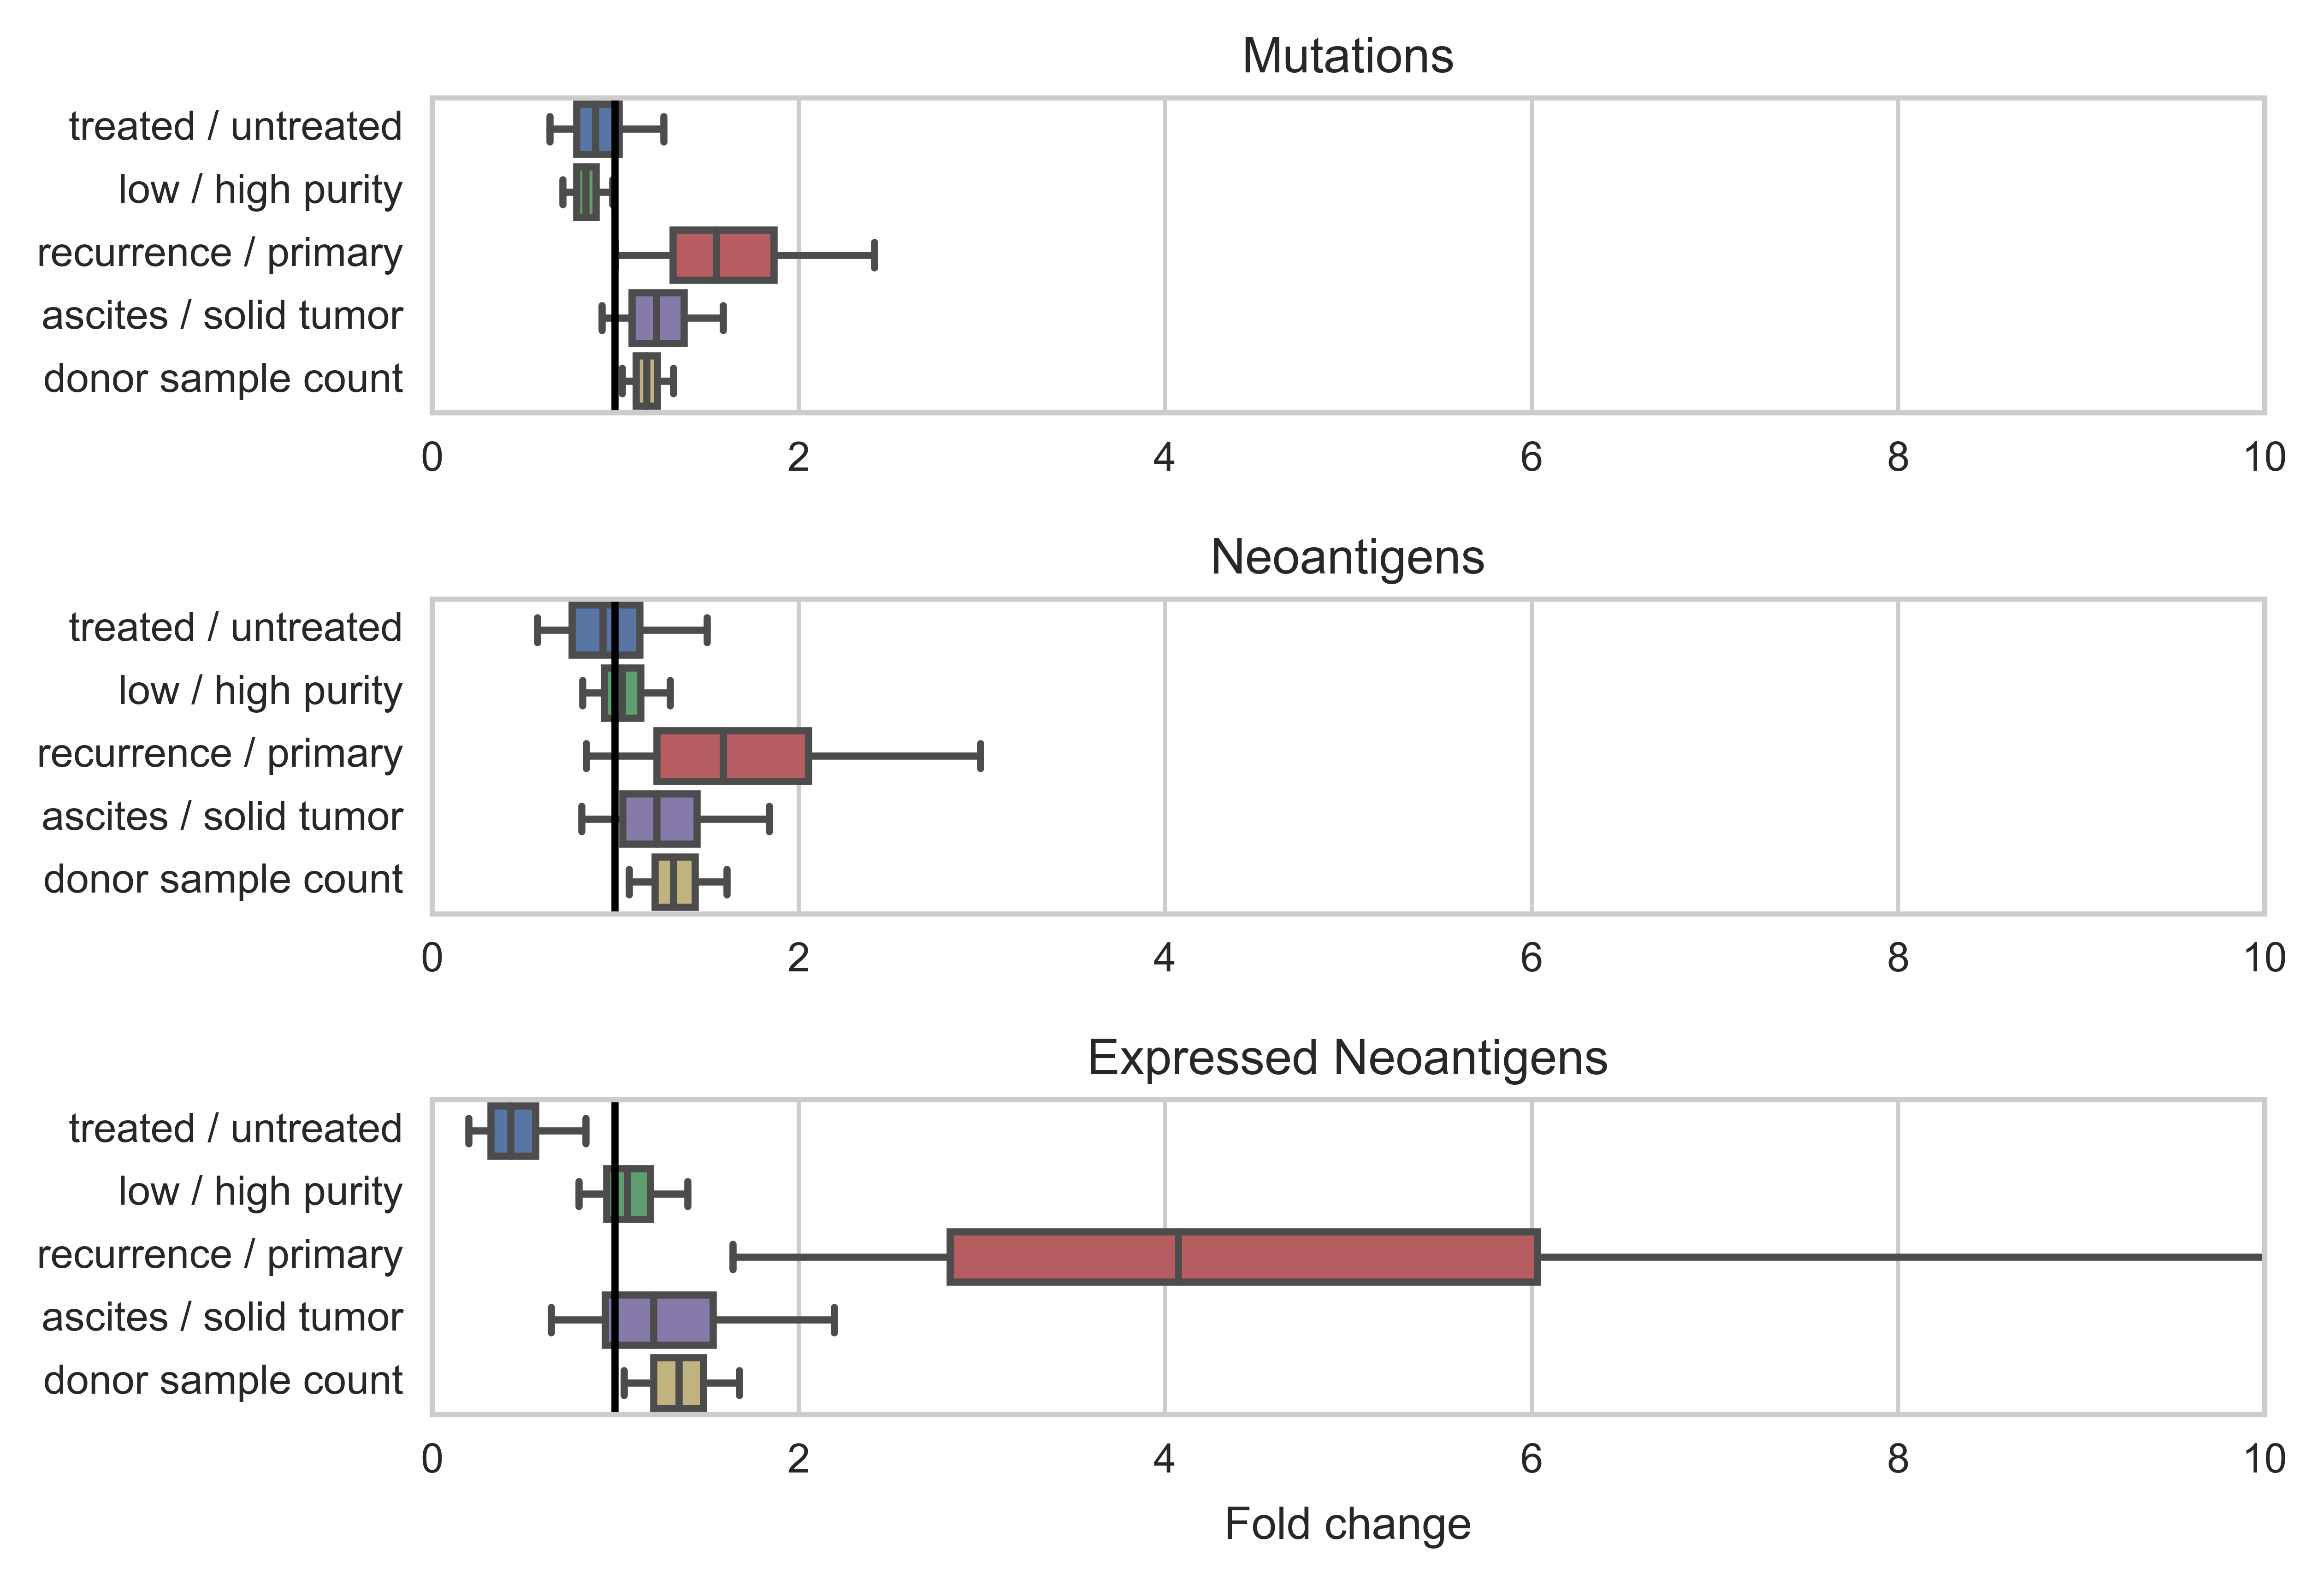

In [14]:
renames = {
    'treated': 'treated / untreated',
    'ascites': 'ascites / solid tumor',
    'low_cellularity': 'low / high purity',
    'solid and treated': 'solid tumor modification of treatment effect',
    'num_sources_for_donor': 'donor sample count',
    'recurrence': 'recurrence / primary',
}

seaborn.set_context('paper')
seaborn.set_style('whitegrid')
pyplot.figure()

titles_and_ylabels = [
    ("Mutations", "mutations"),
    ("Neoantigens", "peptides"),
    ("Expressed Neoantigens", "expressed peptides"),
]
rows = len(titles_and_ylabels)

ax = None
for (row, (title, y_label)) in enumerate(titles_and_ylabels):
    ax = pyplot.subplot(rows, 1, row + 1, sharex=ax)
    pyplot.title(title)
    sub_df = all_fit_coefficients[all_fit_coefficients.y_label == y_label].copy()
    sub_df.columns = [renames.get(c, c) for c in sub_df.columns]
    seaborn.boxplot(
        data=sub_df,
        orient="h",
        whis=[5, 95],
        showbox=True,
        showfliers=False)

    if row + 1 == rows:
        pyplot.xlabel("Fold change")
    pyplot.axvline(1.0, color="black")
    pyplot.xlim(xmin=0, xmax=10)

pyplot.tight_layout()
pyplot.savefig("../figures/bayesian_model_effects_separate.pdf")


In [15]:
mutations = pandas.read_csv("../data/mutations.csv.bz2", converters={'binding_peptides': eval})


In [16]:
sources = pandas.read_csv("../data/sources.extended.csv", index_col="source_id")
sources

,Unnamed: 0,index,donor,cohort,library,treated,timepoint,metastasis,tissue_type,interval_days,assay,paired,timepoint_paired,protein changing,peptides,expressed peptides,mutations,mutations_per_mb,indel,interesting mutations,group,treatment,fraction_peptides_expressed,project_code,study_specimen_involved_in,submitted_specimen_id,icgc_donor_id,submitted_donor_id,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,specimen_donor_treatment_type_other,specimen_processing,specimen_storage,tumour_confirmed,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_stage_system,tumour_stage,percentage_cellularity,level_of_cellularity
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AOCS-001-1/SP101515,0,SP101515,AOCS-001,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,48,124,71,5818,1.938041,1,18.631832,AOCS solid,treatment naive,0.572581,OV-AU,PCAWG,AOCS-001-1,DO46325,AOCS-001,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,73,61-80%
AOCS-002-1/SP101517,1,SP101517,AOCS-002,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,11,32,NaN,1520,0.506329,0,17.236842,AOCS solid,treatment naive,NaN,OV-AU,PCAWG,AOCS-002-1,DO46326,AOCS-002,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,2,FIGO,III,85,>81%
AOCS-004-1/SP101519,2,SP101519,AOCS-004,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,57,58,20,6670,2.221852,1,16.446777,AOCS solid,treatment naive,0.344828,OV-AU,PCAWG,AOCS-004-1,DO46327,AOCS-004,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,77,61-80%
AOCS-005-1/SP101521,3,SP101521,AOCS-005,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,39,61,39,5643,1.879747,2,15.435052,AOCS solid,treatment naive,0.639344,OV-AU,PCAWG,AOCS-005-1,DO46328,AOCS-005,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,90,>81%
AOCS-034-13/SP101524,4,SP101524,AOCS-034,AOCS,WGS,True,recurrence,False,ascites,1597,WGS,True,True,122,266,135,13340,4.443704,5,17.376312,AOCS ascites,chemo treated,0.507519,OV-AU,NaN,AOCS-034-13,DO46329,AOCS-034,Recurrent tumour - other,recurrent ascitic fluid,1597,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8140/3,NaN,NaN,NaN,NaN,99,>81%
AOCS-034-1/SP101523,5,SP101523,AOCS-034,AOCS,WGS,False,primary,False,solid,0,WGS,True,True,73,168,65,6811,2.268821,4,17.970929,AOCS solid,treatment naive,0.386905,OV-AU,PCAWG,AOCS-034-1,DO46329,AOCS-034,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8140/3,Silverberg,3,FIGO,III,84,>81%
AOCS-055-1/SP101526,6,SP101526,AOCS-055,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,114,177,91,14988,4.992672,0,11.182279,AOCS solid,treatment naive,0.514124,OV-AU,PCAWG,AOCS-055-1,DO46330,AOCS-055,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,82,>81%
AOCS-056-1/SP101528,7,SP101528,AOCS-056,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,56,150,16,7012,2.335776,1,20.593269,AOCS solid,treatment naive,0.106667,OV-AU,PCAWG,AOCS-056-1,DO46331,AOCS-056,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,NaN,2,FIGO,III,94,>81%
AOCS-057-1/SP101530,8,SP101530,AOCS-057,AOCS,WGS,False,primary,False,solid,0,WGS,False,False,42,146,NaN,6070,2.021985,5,19.126853,AOCS solid,treatment naive,NaN,OV-AU,PCAWG,AOCS-057-1,DO46332,AOCS-057,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,68,61-80%


In [17]:
# For Table 1, we also need neoantigen etc counts. This was copied from the neoantigen counts notebook.

def mean_with_std(grouped_column, decimals=0):
    pattern = "%%0.%df" % decimals
    return [
        (pattern + " +/ " + pattern) % (m, s) if not pandas.isnull(s) else pattern % m
        for (m, s) in zip(grouped_column.mean(), grouped_column.std())
    ]

def means_with_errorbars(grouped_column, decimals=0, plusminus=False):
    index = []
    values = []
    for (i, grouped) in grouped_column:
        index.append(i)
        values.append(mean_with_errorbars(grouped, decimals=decimals, plusminus=plusminus))
    return pandas.Series(values, index=index)
    
samples_with_rna = mutations.source_id.ix[mutations.rna_total_reads > 0].unique()

grouping_columns = ["cohort", "library", "tissue_type", "treated"]
grouped = sources.groupby(grouping_columns)

df = grouped.donor.nunique().to_frame() #.reset_index()
df["samples"] = grouped.donor.count().to_frame()["donor"]
df["samples with RNA"] = sources.ix[sources.index.isin(samples_with_rna)].groupby(grouping_columns).donor.count().to_frame()["donor"]
df["Mutations"] = means_with_errorbars(grouped.mutations, plusminus=True)
#df["C(C>A)C percent"] = means_with_errorbars(grouped["interesting mutations"], decimals=2)
#df["Protein changing"] = means_with_errorbars(grouped["protein changing"])
df["Neoantigens"] = means_with_errorbars(grouped.peptides, plusminus=True)
df["Expressed"] = means_with_errorbars(grouped["expressed peptides"], plusminus=True)


df = df.reset_index()
df["treated"] = df.treated.map({False: "untreated", True: "post-treatment"})
df["samples"] = ["%d (%d)" % (row.samples, row["samples with RNA"]) for (i, row) in df.iterrows()]
del df["samples with RNA"]
df = df.rename(columns={
        "donor": "donors",
        "treated": "treatment",
        "samples": "samples (RNA)",
        "tissue_type": "tissue type",
    })

#df.to_csv("../data/cohort.csv")
del df["cohort"]
del df["library"]
df.index = ["%s %s" % (row["tissue type"], 'post-treatment' if row["treatment"] != 'untreated' else 'pre-treatment') for (i, row) in df.iterrows()]
del df["tissue type"]
del df["treatment"]
del df["donors"]
df = df.applymap(str)
df
print(df.to_latex(index=True, index_names=False, escape=False))
df

\begin{tabular}{lllll}
\toprule
{} & samples (RNA) &         Mutations &   Neoantigens &     Expressed \\
\midrule
ascites pre-treatment  &         4 (4) &   10148 $\pm$ 800 &  199 $\pm$ 60 &   78 $\pm$ 30 \\
ascites post-treatment &       24 (20) &  13428 $\pm$ 1000 &  295 $\pm$ 50 &  143 $\pm$ 30 \\
solid pre-treatment    &       76 (70) &    7806 $\pm$ 900 &  152 $\pm$ 20 &    63 $\pm$ 9 \\
solid post-treatment   &        11 (4) &  11079 $\pm$ 3000 &  264 $\pm$ 80 &   38 $\pm$ 20 \\
\bottomrule
\end{tabular}



,samples (RNA),Mutations,Neoantigens,Expressed
ascites pre-treatment,4 (4),10148 $\pm$ 800,199 $\pm$ 60,78 $\pm$ 30
ascites post-treatment,24 (20),13428 $\pm$ 1000,295 $\pm$ 50,143 $\pm$ 30
solid pre-treatment,76 (70),7806 $\pm$ 900,152 $\pm$ 20,63 $\pm$ 9
solid post-treatment,11 (4),11079 $\pm$ 3000,264 $\pm$ 80,38 $\pm$ 20


In [18]:
sources.groupby(["timepoint", "tissue_type", "treated"]).donor.count()

timepoint   tissue_type  treated
primary     ascites      False       4
            solid        False      76
                         True        5
recurrence  ascites      True       24
            solid        True        6
Name: donor, dtype: int64

In [19]:
sources.ix[sources.treated & (sources.timepoint == "primary")]

,Unnamed: 0,index,donor,cohort,library,treated,timepoint,metastasis,tissue_type,interval_days,assay,paired,timepoint_paired,protein changing,peptides,expressed peptides,mutations,mutations_per_mb,indel,interesting mutations,group,treatment,fraction_peptides_expressed,project_code,study_specimen_involved_in,submitted_specimen_id,icgc_donor_id,submitted_donor_id,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,specimen_donor_treatment_type_other,specimen_processing,specimen_storage,tumour_confirmed,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_stage_system,tumour_stage,percentage_cellularity,level_of_cellularity
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AOCS-077-1/SP101572,20,SP101572,AOCS-077,AOCS,WGS,True,primary,False,solid,75,WGS,False,False,37,85,16,3053,1.016989,2,16.344579,AOCS solid,chemo treated,0.188235,OV-AU,PCAWG,AOCS-077-1,DO46350,AOCS-077,Primary tumour - solid tissue,NaN,75,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,53,41-60%
AOCS-106-1/SP101670,48,SP101670,AOCS-106,AOCS,WGS,True,primary,False,solid,39,WGS,False,False,116,306,44,13267,4.419387,9,20.524610,AOCS solid,chemo treated,0.143791,OV-AU,PCAWG,AOCS-106-1,DO46390,AOCS-106,Primary tumour - solid tissue,NaN,39,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8441/3,Silverberg,2,FIGO,III,97,>81%
AOCS-158-1/SP102064,97,SP102064,AOCS-158,AOCS,WGS,True,primary,False,solid,40,WGS,False,False,68,242,NaN,6933,2.309460,9,22.183759,AOCS solid,chemo treated,NaN,OV-AU,PCAWG,AOCS-158-1,DO46561,AOCS-158,Primary tumour - solid tissue,NaN,40,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3,FIGO,III,94,>81%
AOCS-162-1/SP102096,101,SP102096,AOCS-162,AOCS,WGS,True,primary,False,solid,63,WGS,False,False,34,62,11,5182,1.726183,2,16.325743,AOCS solid,chemo treated,0.177419,OV-AU,PCAWG,AOCS-162-1,DO46576,AOCS-162,Primary tumour - solid tissue,NaN,63,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8441/3,NaN,3,FIGO,III,89,>81%
AOCS-169-1/SP102168,110,SP102168,AOCS-169,AOCS,WGS,True,primary,False,solid,108,WGS,False,False,31,36,NaN,4448,1.481679,1,18.637590,AOCS solid,chemo treated,NaN,OV-AU,PCAWG,AOCS-169-1,DO46602,AOCS-169,Primary tumour - solid tissue,NaN,108,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8441/3,NaN,3,FIGO,III,73,61-80%


In [21]:
'''
def effect(effect, y_label):
    sub_df = all_fit_coefficients.ix[all_fit_coefficients.y_label == y_label]
    # if solid and y_label == "expressed peptides":
    #if solid:
    #    effect = sub_df["treated"] * sub_df["solid and treated"]
    #else:
    #    effect = sub_df["treated"]
    effect = sub_df["treated"]
    result = (effect - 1.0) * 100.0
    #return r"%.2f $\pm$ %0.2f" % (result.mean(), (result.std()) * 2)

    return r"%.0f $\pm$ %0.0f" % (result.mean(), (result.quantile(0.95) - result.quantile(0.05)) / 2)

additional_rows = [
    ("Treatment effect", "treated"),
    ("Recurrence effect", "recurrence"),
    ("Treated and recurrence effect", "recurrence"),


]

df_with_model = pandas.concat([
    df,
    pandas.DataFrame({
            'Treatment effect': [effect("treated", "mutations")],
                
                
            'Neoantigens': [treatment_effect("peptides", False), treatment_effect("peptides", True)],
            'Expressed': [treatment_effect("expressed peptides", False), treatment_effect("expressed peptides", True)],
            }, index=["ascites model-adjusted percent change", "solid model-adjusted percent change"])
], ignore_index=False).fillna('')[df.columns]
df_with_model = df_with_model.ix[sorted(df_with_model.index,
                                        key=lambda x: ('ascites' not in x, 'pre' not in x, 'post' not in x, 'effect' not in x))]

df_with_model.rename(columns={'Expressed': 'Expressed Neoantigens'}, inplace=True)

as_latex_lines = df_with_model.to_latex(index=True, index_names=False, escape=False).split("\n")
last_ascites = max(num for (num, line) in enumerate(as_latex_lines) if 'ascites' in line)
as_latex_lines.insert(last_ascites + 1, r"\hline")
as_latex_lines = [
    x.replace("ascites model-adjusted", "model-adjusted")
    .replace("solid model-adjusted", "model-adjusted")
    for x in as_latex_lines
]


print("\n".join(as_latex_lines).replace("model-adjusted percent change", r"\textit{model adjusted change (\%)}"))
df_with_model
'''

'\ndef effect(effect, y_label):\n    sub_df = all_fit_coefficients.ix[all_fit_coefficients.y_label == y_label]\n    # if solid and y_label == "expressed peptides":\n    #if solid:\n    #    effect = sub_df["treated"] * sub_df["solid and treated"]\n    #else:\n    #    effect = sub_df["treated"]\n    effect = sub_df["treated"]\n    result = (effect - 1.0) * 100.0\n    #return r"%.2f $\\pm$ %0.2f" % (result.mean(), (result.std()) * 2)\n\n    return r"%.0f $\\pm$ %0.0f" % (result.mean(), (result.quantile(0.95) - result.quantile(0.05)) / 2)\n\nadditional_rows = [\n    ("Treatment effect", "treated"),\n    ("Recurrence effect", "recurrence"),\n    ("Treated and recurrence effect", "recurrence"),\n\n\n]\n\ndf_with_model = pandas.concat([\n    df,\n    pandas.DataFrame({\n            \'Treatment effect\': [effect("treated", "mutations")],\n                \n                \n            \'Neoantigens\': [treatment_effect("peptides", False), treatment_effect("peptides", True)],\n            \'

In [23]:
'''
def treatment_effect(y_label, solid):
    sub_df = all_fit_coefficients.ix[all_fit_coefficients.y_label == y_label]
    #if solid and y_label == "expressed peptides":
    if solid:
        effect = sub_df["treated"] * sub_df["solid and treated"]
    else:
        effect = sub_df["treated"]
    result = (effect - 1.0) * 100.0
    #return r"%.2f $\pm$ %0.2f" % (result.mean(), (result.std()) * 2)

    return r"%.0f $\pm$ %0.0f" % (result.mean(), (result.quantile(0.95) - result.quantile(0.05)) / 2)

df_with_model = pandas.concat([
    df,
    pandas.DataFrame({
            'Mutations': [treatment_effect("mutations", False), treatment_effect("mutations", True)],
            'Neoantigens': [treatment_effect("peptides", False), treatment_effect("peptides", True)],
            'Expressed': [treatment_effect("expressed peptides", False), treatment_effect("expressed peptides", True)],
            }, index=["ascites model-adjusted percent change", "solid model-adjusted percent change"])
], ignore_index=False).fillna('')[df.columns]
df_with_model = df_with_model.ix[sorted(df_with_model.index,
                                        key=lambda x: ('ascites' not in x, 'pre' not in x, 'post' not in x, 'effect' not in x))]

df_with_model.rename(columns={'Expressed': 'Expressed Neoantigens'}, inplace=True)

as_latex_lines = df_with_model.to_latex(index=True, index_names=False, escape=False).split("\n")
last_ascites = max(num for (num, line) in enumerate(as_latex_lines) if 'ascites' in line)
as_latex_lines.insert(last_ascites + 1, r"\hline")
as_latex_lines = [
    x.replace("ascites model-adjusted", "model-adjusted")
    .replace("solid model-adjusted", "model-adjusted")
    for x in as_latex_lines
]


print("\n".join(as_latex_lines).replace("model-adjusted percent change", r"\textit{model adjusted change (\%)}"))
df_with_model
'''

'\ndef treatment_effect(y_label, solid):\n    sub_df = all_fit_coefficients.ix[all_fit_coefficients.y_label == y_label]\n    #if solid and y_label == "expressed peptides":\n    if solid:\n        effect = sub_df["treated"] * sub_df["solid and treated"]\n    else:\n        effect = sub_df["treated"]\n    result = (effect - 1.0) * 100.0\n    #return r"%.2f $\\pm$ %0.2f" % (result.mean(), (result.std()) * 2)\n\n    return r"%.0f $\\pm$ %0.0f" % (result.mean(), (result.quantile(0.95) - result.quantile(0.05)) / 2)\n\ndf_with_model = pandas.concat([\n    df,\n    pandas.DataFrame({\n            \'Mutations\': [treatment_effect("mutations", False), treatment_effect("mutations", True)],\n            \'Neoantigens\': [treatment_effect("peptides", False), treatment_effect("peptides", True)],\n            \'Expressed\': [treatment_effect("expressed peptides", False), treatment_effect("expressed peptides", True)],\n            }, index=["ascites model-adjusted percent change", "solid model-adjuste

In [ ]:
'''
def round_series(s):
    return pandas.Series(numpy.round(s.values, 0), index=s.index)

for y_label in fit_results:
    print(y_label)
    print(round_series(all_fit_coefficients[all_fit_coefficients.y_label == y_label].quantile(0.5)*100 - 100))
    print("--")

    print(round_series(all_fit_coefficients[all_fit_coefficients.y_label == y_label].quantile(0.05)*100 - 100))
    print(round_series(all_fit_coefficients[all_fit_coefficients.y_label == y_label].quantile(0.95)*100 - 100))
    print("")
    
'''

In [ ]:
'''
for quantile in [0.5, 0.05, 0.95]:
    sub = all_fit_coefficients.ix[all_fit_coefficients.y_label == "expressed peptides"]
    print(quantile,
          "plain",
          numpy.round(sub["treated"].quantile(quantile) * 100 - 100, 0))
    print(quantile,
          "solid",
          numpy.round((sub["treated"] * sub["solid and treated"]).quantile(quantile) * 100 - 100, 0))
'''